In [1]:
import numpy as np
import osmnx as ox
import networkx as nx 
import pandas as pd 
import matplotlib.pyplot as plt
import copy 
%matplotlib inline

## Download graph

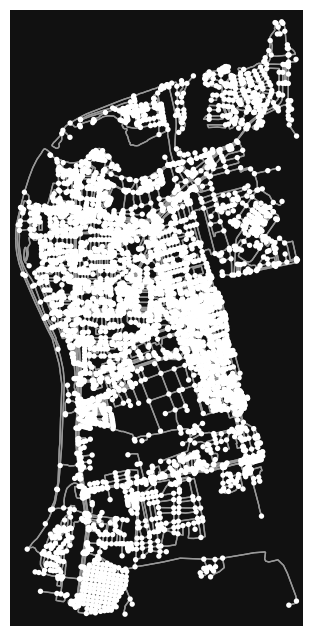

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
#Файл можно скачать на сайте OpenStreetMap --> Экспорт --> Навестись на область карты --> кликнуть Overpass Api
# osm_file_path = "/home/igoreshka/Downloads/map (2)"
# graph = ox.graph_from_xml(osm_file_path, simplify=True)

# Долгопрудный
graph = ox.graph_from_place('Dolgoprudny, Russia')

ox.plot_graph(ox.project_graph(graph))

## Graph description

In [ ]:
for u, v, key, edge_data in graph.edges(keys=True, data=True):
    print(edge_data)
for node in graph.nodes():
    print(graph.nodes[node])
    

In [ ]:
for u, v, key, edge_data in graph.edges(keys=True, data=True):
    print(edge_data.keys())


## Delete small roads

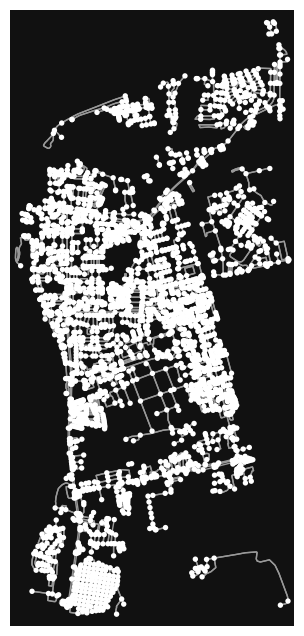

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [13]:
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

result_graph = copy.deepcopy(graph)

# Какие типы дорог хотим оставить

need_keys = ['length','oneway','reversed']
highway_types = ["motorway", "trunk", "primary", "secondary",'service']

edges_to_remove = []
for u, v, key, edge_data in result_graph.edges(keys=True, data=True):
    # KEYS FILTER
    for need_key in need_keys :
        if need_key not in edge_data.keys() :
            edges_to_remove.append((u, v, key))
            break
    # HIGHWAY FILTER
    if 'highway' not in edge_data.keys() :
        edges_to_remove.append((u, v, key))
    else :
        if type(edge_data['highway']) == type(""):
            if edge_data['highway'] not in highway_types :
                edges_to_remove.append((u, v, key))
        else :
            for highway_type in edge_data['highway'] :
                if highway_type not in highway_types :
                    edges_to_remove.append((u, v, key))
                    break
for u, v, key in set(edges_to_remove):
    result_graph.remove_edge(u, v, key)

# Получение списка вершин без ребер
isolated_nodes = [node for node in result_graph.nodes() if result_graph.degree(node) == 0]

# Удаление вершин без ребер
result_graph.remove_nodes_from(isolated_nodes)

ox.plot_graph(ox.project_graph(result_graph))

## Convert result graph to dataframe

In [4]:
df = pd.DataFrame(result_graph.edges(data=True),columns=['Init Node' , 'Term Node' , 'data'])
df['data'][22]

{'osmid': 544655999,
 'highway': 'service',
 'oneway': False,
 'reversed': False,
 'length': 30.329,
 'geometry': <LINESTRING (37.499 55.939, 37.499 55.939, 37.499 55.939, 37.499 55.939, 37....>}

In [27]:
df = pd.DataFrame(result_graph.edges(data=True),columns=['Init Node' , 'Term Node' , 'data'])


# малые дороги : lanes = 1 
df['capacity'] = df['data'].apply(lambda x: x['lanes'] if 'lanes' in x.keys()  else 1 )

#maxspeed пока по дефолту 32 км/ч = 10 м/c --> Итоговая величина: сек
def getfreeflowtime(x) :
    return int(x['length'])/int(x['maxspeed'])*10/32 if 'maxspeed' in x.keys() and type(x['maxspeed']) == type("") and x['maxspeed'].isdigit() else int(x['length'])/10 
df['free flow time'] = df['data'].apply(getfreeflowtime)

df['length'] = df['data'].apply(lambda x: x['length'])
df['reversed'] = df['data'].apply(lambda x: x['reversed'])
df['oneway'] = df['data'].apply(lambda x: x['oneway'])


df.drop('data', axis=1, inplace=True)

df.head(10)

,Init Node,Term Node,capacity,free flow time,length,reversed,oneway
0,27782964,1672913228,1,0.093750,12.112,True,False
1,27782964,27782988,1,0.976562,125.612,False,False
2,27782988,1516138003,1,0.234375,45.631,True,False
3,27782988,27782964,1,0.976562,125.612,True,False
4,27782989,1747383233,1,0.197917,38.784,True,False
5,27782989,1516138003,1,0.255208,49.499,False,False
6,27783013,7233896814,1,0.600000,6.983,False,False
7,60450985,1298213058,2,0.213542,41.683,False,False
8,60450985,5094347212,2,0.800000,8.040,False,False
9,60450989,1126419926,2,0.900000,9.634,True,False


## Кореспонденции
Список смежности : где находимся -->(сколько нас)--> куда хотим попасть 

In [46]:
nodes = result_graph.nodes(data=True)
nodes = np.array(nodes)
print(nodes[0][0],nodes[0][1])

27782964 {'y': 55.9477602, 'x': 37.4915544, 'street_count': 4}


In [54]:
graph_correspondences = dict()
graph_correspondences[nodes[0][0]] = {'targets' : [nodes[4][0]],'corrs' : [100]}
for i in range(1,len(nodes)) :
    graph_correspondences[nodes[i][0]] = {'targets' : [nodes[i-1][0]],'corrs' : [100]}
print(graph_correspondences)

{27782964: {'targets': [60450985], 'corrs': [100]}, 27782988: {'targets': [27782964], 'corrs': [100]}, 27782989: {'targets': [27782988], 'corrs': [100]}, 27783013: {'targets': [27782989], 'corrs': [100]}, 60450985: {'targets': [27783013], 'corrs': [100]}, 60450989: {'targets': [60450985], 'corrs': [100]}, 60450990: {'targets': [60450989], 'corrs': [100]}, 60452055: {'targets': [60450990], 'corrs': [100]}, 60452056: {'targets': [60452055], 'corrs': [100]}, 60452057: {'targets': [60452056], 'corrs': [100]}, 60452074: {'targets': [60452057], 'corrs': [100]}, 60452077: {'targets': [60452074], 'corrs': [100]}, 60453069: {'targets': [60452077], 'corrs': [100]}, 60453072: {'targets': [60453069], 'corrs': [100]}, 66387088: {'targets': [60453072], 'corrs': [100]}, 66387102: {'targets': [66387088], 'corrs': [100]}, 72427730: {'targets': [66387102], 'corrs': [100]}, 72427745: {'targets': [72427730], 'corrs': [100]}, 72427757: {'targets': [72427745], 'corrs': [100]}, 77561375: {'targets': [7242775